Evan Perez


# 1. Load data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/CTP_data/FRAUD/Fraud.csv')

#look at first 5 entries
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 2. Data Exploration

In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
any(df.duplicated())

False

<Axes: >

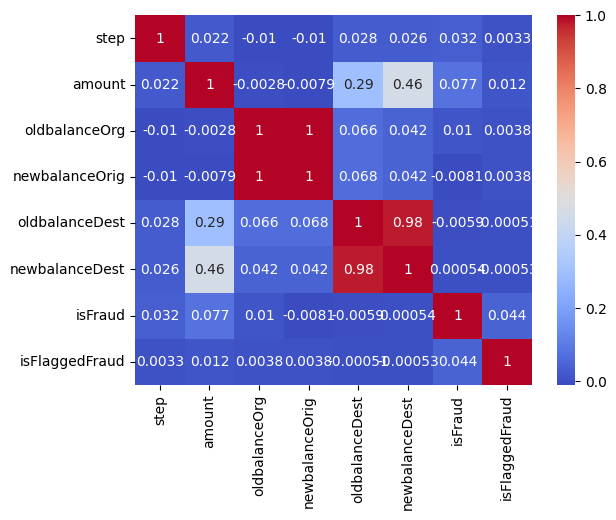

In [ ]:
#Test for Multicollinearity
col = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud']

corr_matrix = df[col].corr()

sns.heatmap(data=corr_matrix, annot=True,cmap='coolwarm')



* Old/New Balance data correlate with each other too much, which indicates multicollinearity. We will remove the old balance data

In [ ]:
#Visualize the relationship between Step(time) and Amount in terms of Fraud labels

plt.figure(figsize=(10,6))

sns.scatterplot(data=df, x='amount', y='step',hue='isFraud', alpha=0.5)

plt.xlabel('Step')
plt.ylabel('Amount')
plt.title('Scatter Plot of Step vs. Amount')

plt.grid(True)
plt.tight_layout()
plt.legend(title='Is Fraud')
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7e8bcb215000> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7e8bcb214280> (for post_execute):


KeyboardInterrupt: 

* Above we can see that all of the fraudulent labels fall within a step size of 0 and 1 approximately 1 hour of a transaction occuring

In [ ]:
#What is the ratio for true and false labels? (Fraud and not fraud)

plt.pie(df['isFraud'].value_counts(), autopct='%.2f')
plt.legend(title='Fraud Label', labels=['Not Fraud (0)', 'Fraud (1)'], loc='upper right')
plt.title('Distribution of Fraud Labels')

* The ratio for fraud and not fraud entries is highly disproportionate. The amount of true fraudulent entries is extrememly low.

In [ ]:
#Count the number of fraud labels in each payment type category

#group by payment types and count the number of occurences of fraud
fraud_tally = df.groupby('type')['isFraud'].value_counts()


fraud_tally.plot(kind='bar')
plt.xlabel('Payment Types')
plt.ylabel('Count')
plt.title('Counts of Fraud wihtin Payment Categories')
plt.xticks(rotation=45,ha='right')
plt.show()

* Fraudulent transactions occure only in CASH OUT and TRANSFER payment categories

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
df.boxplot(ax=ax)
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Dataframe Features Boxplot')
plt.xticks(rotation=45, ha='right')
plt.show()

* There appears to be outliers in amount, oldbalanceDest, newbalanceDest

In [ ]:
#Count unique values in nameOrig and nameDest

nameOrig_tally = df['nameOrig'].value_counts()
nameDest_tally = df['nameDest'].value_counts()

print("Value counts in nameOrig")
print(nameOrig_tally)
print()

print("Value counts in nameDes")
print(nameDest_tally)

* We already hypothesized that the names of the origin/dest would not be helpful in predicting fraud. The high number of unique names though confirms that these names will not help us

#3. Data Handling and Feature Engieering

In [ ]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


* We can make a new column called 'percent_change' which can better capture how much an account's balance changes

* We know that we want to remove oldbalance data since it has a high correlation with newbalance data.

* We need to convert out categorical data into numerical data

* We need to remove redundant data that won't help in classifying fraud, such as the names of the origin of the transaction and destination. We also want to remove the 'flaggedFraud' feature sinc we are the ones who are predicting fraud or not.

* We need to upscale our fraudulent transaction data so we can remove the imbalance and our models have enough data in both fraud/non fraud to train on

Percent Change

In [ ]:
import numpy as np

df["per_change"] = ((df["newbalanceOrig"] - df["oldbalanceOrg"])/(df["oldbalanceOrg"]))
df["per_change"] = pd.Series(np.where(df["oldbalanceOrg"] == 0.0,0,df["per_change"]))

df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,per_change
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,-0.057834
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,-0.087735
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,-1.000000
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,-1.000000
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,-0.280795


Check for multicollinearity again

<Axes: >

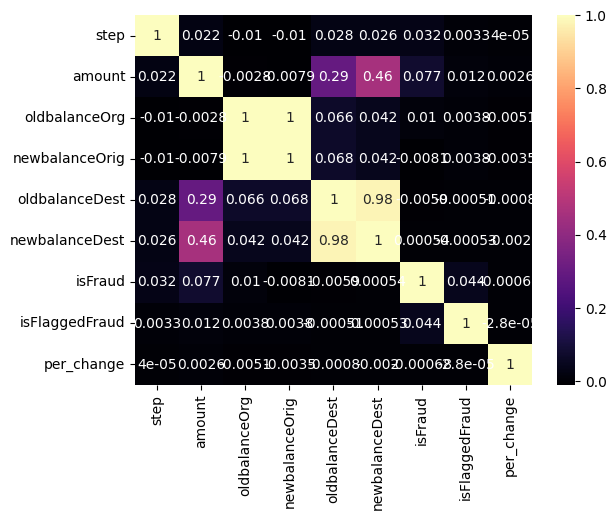

In [ ]:
#Test for Multicollinearity
col = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud','per_change']

corr_matrix = df[col].corr()

sns.heatmap(data=corr_matrix, annot=True,cmap='magma')


Encode categorial data

In [ ]:
df = pd.get_dummies(df, columns=['type'], drop_first=False)
df.head(5)

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,per_change,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,-0.057834,False,False,False,True,False
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,-0.087735,False,False,False,True,False
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,-1.000000,False,False,False,False,True
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,-1.000000,False,True,False,False,False
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,-0.280795,False,False,False,True,False


Remove redundant data

In [ ]:
df = df.drop(columns=['isFlaggedFraud','oldbalanceOrg','oldbalanceDest','nameOrig','nameDest', 'type_CASH_IN','type_DEBIT','type_PAYMENT'])
df.head(5)

,step,amount,newbalanceOrig,newbalanceDest,isFraud,per_change,type_CASH_OUT,type_TRANSFER
0,1,9839.64,160296.36,0.0,0,-0.057834,False,False
1,1,1864.28,19384.72,0.0,0,-0.087735,False,False
2,1,181.00,0.00,0.0,1,-1.000000,False,True
3,1,181.00,0.00,0.0,1,-1.000000,True,False
4,1,11668.14,29885.86,0.0,0,-0.280795,False,False


Check for mulicollineary one more time

<Axes: >

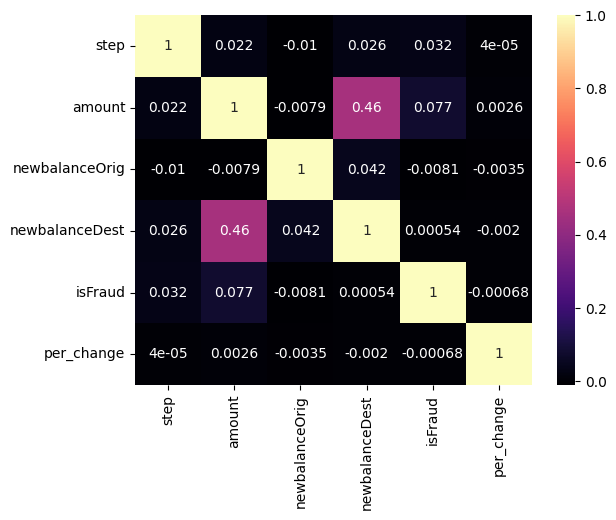

In [ ]:
#Test for Multicollinearity
col = ['step','amount','newbalanceOrig','newbalanceDest','isFraud','per_change']

corr_matrix = df[col].corr()

sns.heatmap(data=corr_matrix, annot=True,cmap='magma')

* NewbalanceDest and Amount show a higher value of corellation, but we will disregard this since it is below 50%

Balance the data

In [ ]:
from imblearn.over_sampling import SMOTE

df = df.sample(n=600000, random_state=42)

X = df.drop('isFraud', axis=1)
y = df['isFraud']

smote = SMOTE(sampling_strategy='auto', random_state=42)
X,y = smote.fit_resample(X,y)

In [ ]:
y.value_counts()

isFraud
0    599240
1    599240
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Fraud Labels')

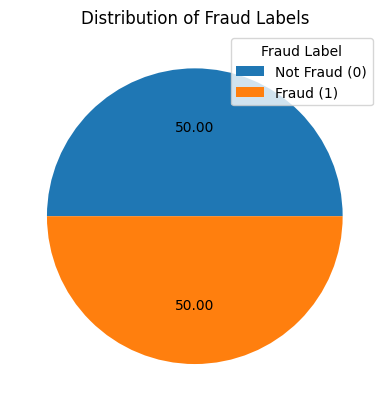

In [ ]:
plt.pie(y.value_counts(), autopct='%.2f')
plt.legend(title='Fraud Label', labels=['Not Fraud (0)', 'Fraud (1)'], loc='upper right')
plt.title('Distribution of Fraud Labels')

* As we can see, the data is now balanced. We have an equal amount of fraudulent and non fraudulent transactions

Remove Outliers

In [ ]:
numeric_columns = df.select_dtypes(include=['int64','float64'])

# Calculate quantiles for numeric columns
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# The rest of your code to detect outliers should remain the same
def detect_outliers(column):
    lower_bound = Q1[column] - 1.5 * IQR[column]
    upper_bound = Q3[column] + 1.5 * IQR[column]
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    if outliers.empty:
        return None, 0.0
    else:
        percentage = (len(outliers) / len(df)) * 100
        return column, percentage

columns_with_outliers = [detect_outliers(column) for column in numeric_columns.columns]
columns_with_outliers = [(column, percentage) for column, percentage in columns_with_outliers if column is not None]

for column, percentage in columns_with_outliers:
    print(f"Column: {column}, Percentage of outliers: {percentage:.2f}%")

Column: step, Percentage of outliers: 1.63%
Column: amount, Percentage of outliers: 5.33%
Column: newbalanceOrig, Percentage of outliers: 16.55%
Column: newbalanceDest, Percentage of outliers: 11.61%
Column: isFraud, Percentage of outliers: 0.13%
Column: per_change, Percentage of outliers: 6.95%


In [ ]:
# removing outliers
def remove_outlier(col):
    sorted(col)
    Q1,Q3=col.quantile([0.25,0.75])
    IQR=Q3-Q1
    lower_range=Q1-1.5*IQR
    upper_range=Q3+1.5*IQR
    return lower_range,upper_range

In [ ]:
# Specify the columns you want to remove outliers from
columns_to_remove_outliers = ['step', 'amount', 'newbalanceOrig', 'newbalanceDest', 'per_change']

for col in columns_to_remove_outliers:
    low_threshold, high_threshold = remove_outlier(df[col])
    df[col] = np.where(df[col] > high_threshold, high_threshold, df[col])
    df[col] = np.where(df[col] < low_threshold, low_threshold, df[col])

Split the data and then normalize the X data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#turns 25% of the training data into validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
X_train.head(20)

,step,amount,newbalanceOrig,newbalanceDest,per_change,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
133160,136,1.608906e+05,0.00,6.133638e+05,0.000000,False,True,False,False,False
710913,632,1.604190e+05,0.00,4.546076e+05,-1.000000,False,True,False,False,False
1198191,156,7.490180e+05,0.00,1.103234e+06,-1.000000,False,True,False,False,False
1196928,374,1.230579e+06,0.00,1.333576e+06,-1.000000,False,True,False,False,False
285161,590,1.885685e+06,0.00,2.984467e+06,-1.000000,False,False,False,False,True
501379,323,2.717452e+05,0.00,1.885310e+06,-1.000000,False,True,False,False,False
324994,227,1.738180e+05,0.00,2.889528e+05,-1.000000,False,True,False,False,False
925515,375,7.012295e+05,0.00,0.000000e+00,-1.000000,False,False,False,False,True
34078,156,5.568517e+05,0.00,4.263609e+06,0.000000,False,True,False,False,False
556519,209,7.027809e+04,131303.91,7.027809e+04,-0.348633,False,True,False,False,False


In [ ]:
from sklearn.preprocessing import MinMaxScaler
#Normalizes x data

scaler  = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

print(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


[[1.82186235e-01 2.50473982e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.51551957e-01 2.49739826e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.09176788e-01 1.16606901e-02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.22807018e-01 1.47794387e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.21187584e-01 2.82323302e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.61268556e-01 1.10660356e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


#4. Logistic Regression

In [ ]:
sc=StandardScaler()
X_train_scLGR = sc.fit_transform(X_train)
X_test_scLGR = sc.transform(X_test)

In [ ]:
lgr = LogisticRegression(max_iter=500)
lgr.fit(X_train_scLGR, y_train)

LogisticRegression(max_iter=500)

In [ ]:
y_pred_test_LGR = lgr.predict(X_test_scLGR)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Assuming you have y_test_LGR and y_pred_test_LGR from your predictions
# Calculate accuracy
LGR_accuracy = accuracy_score(y_test, y_pred_test_LGR)
print("Accuracy:", LGR_accuracy)

# Print classification report
print(classification_report(y_test, y_pred_test_LGR))

Accuracy: 0.8497888992724117
              precision    recall  f1-score   support

           0       0.88      0.81      0.84    119749
           1       0.82      0.89      0.86    119947

    accuracy                           0.85    239696
   macro avg       0.85      0.85      0.85    239696
weighted avg       0.85      0.85      0.85    239696



# Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(random_state = 42)

rf_model.fit(X_train,y_train)


RandomForestClassifier(random_state=42)

In [ ]:
# Make predictions on the test set
RF_predictions = rf_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

RF_accuracy = accuracy_score(y_test, RF_predictions)
print("Accuracy:", RF_accuracy)

# You can also print a classification report for more detailed evaluation
print(classification_report(y_test, RF_predictions))

Accuracy: 0.9936544623189373
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    119749
           1       0.99      1.00      0.99    119947

    accuracy                           0.99    239696
   macro avg       0.99      0.99      0.99    239696
weighted avg       0.99      0.99      0.99    239696



# Neural Network

In [ ]:
# Parameters
#//////////////////////
learning_rate = 0.001
epochs = 30
batch_size = 64
#/////////////////////

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU

model = Sequential([
    Dense(units=10, input_shape=(X_train.shape[-1],)),
    LeakyReLU(alpha=0.01),  # LeakyReLU after the first Dense layer

    Dense(units=20),
    LeakyReLU(alpha=0.01),  # LeakyReLU after the second Dense layer

    Dense(units=150),
    LeakyReLU(alpha=0.01),  # LeakyReLU after the third Dense layer

    Dropout(0.1),  # Dropout layer remains the same

    Dense(units=20),
    LeakyReLU(alpha=0.01),  # LeakyReLU after the fourth Dense layer

    Dense(units=1, activation='sigmoid')  # Output layer
])
# Summary of the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 10)                110       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 10)                0         
                                                                 
 dense_21 (Dense)            (None, 20)                220       
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_22 (Dense)            (None, 150)               3150      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 150)               0         
                                                                 
 dropout_4 (Dropout)         (None, 150)              

In [ ]:
from tensorflow import keras
# Compile the model with an optimizer

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,  ModelCheckpoint

# Define the learning rate reduction callback
lr_reduction = ReduceLROnPlateau(
    monitor="val_loss",  # metric to monitor
    factor=0.1,  # factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,  # number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,  # lower bound on the learning rate
    verbose=1,  # verbosity mode
)

early_stopping = EarlyStopping(
    min_delta = 0.0002, # minimium amount of change to count as an improvement
    patience  = 20,     # how many epochs to wait before stopping
    restore_best_weights=True,
)

model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/CTP_FRAUD_STORAGE/models/',
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(X_val, y_val),
          verbose=1,
          callbacks=[lr_reduction, early_stopping, model_checkpoint])

Epoch 1/30
11236/11236 [==============================] - 57s 5ms/step - loss: 0.2327 - accuracy: 0.8903 - val_loss: 355019136.0000 - val_accuracy: 0.6337 - lr: 0.0010
Epoch 2/30
11236/11236 [==============================] - 57s 5ms/step - loss: 0.1772 - accuracy: 0.9194 - val_loss: 919294784.0000 - val_accuracy: 0.6282 - lr: 0.0010
Epoch 3/30
11236/11236 [==============================] - 57s 5ms/step - loss: 0.1682 - accuracy: 0.9236 - val_loss: 1076896256.0000 - val_accuracy: 0.6282 - lr: 0.0010
Epoch 4/30
11236/11236 [==============================] - 54s 5ms/step - loss: 0.1631 - accuracy: 0.9255 - val_loss: 777410880.0000 - val_accuracy: 0.6256 - lr: 0.0010
Epoch 5/30
11236/11236 [==============================] - 55s 5ms/step - loss: 0.1601 - accuracy: 0.9267 - val_loss: 697769984.0000 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 6/30
11224/11236 [============================>.] - ETA: 0s - loss: 0.1581 - accuracy: 0.9275
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001

KeyboardInterrupt: 

In [ ]:
final = model.predict(X_test)
y_pred = (final > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='g', cmap='inferno')  # 'g' format makes sure integers are displayed properly
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Ideas
- try various architecures
- grid search
- how to identify most importnant features?
- train on all samples?